## AK IFSAR DEM tiles preprocessing for PARGE w/ HySpex

5 m GSD IFSAR tiles (covering Alaska) can be downloaded from various sources. Depending on the source the packaging varies. What we need is tiles as single GeoTIFF files, each with a vector file associated that contains the outline polygon.

Files from https://earthexplorer.usgs.gov/ come in a convenient format: one folder (zipped) per dataset, one GeoTIFF and associated Shapefile per folder.

Files from https://viewer.nationalmap.gov/advanced-viewer/ (make sure you download the IFSAR DSM GeoTIFF tiles, not the ARCGrid version) have several tiles per zipfile and don't come with Shapefile. To make up for it we run `gdaltindex` in each unzipped directory to create a shapefile tile index, one feature per GeoTIFF file. The filename is then an attribute of the feature.  

In [ ]:
import os
import sys
import glob
import json
from collections import namedtuple
import pandas as pd
import geopandas as gp
import rasterio as rio
import rasterio.mask 
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.merge import merge
import fiona

In [ ]:
projectdir = "Z:\\fihyper\\cwaigl\\20190826_BC"
gis_subdir = "00_aux\\GIS\\Flightline"

Optional: add metadata fields

In [ ]:
author = None
author = "Chris Waigl, cwaigl@alaska.edu"

In [ ]:
global_meta = {}

if author:
    global_meta['author'] = author

### Load flightline data

Load flightline, create envelope both in Alaska Albers and UTM 6N 

In [ ]:
flightlinedf

,Shape_Leng,geometry
0,220517.498251,"LINESTRING Z (291753.463 1663587.892 143.022, ..."


In [ ]:
flightlinedf = gp.read_file(
    glob.glob(os.path.join(projectdir, gis_subdir, "*useable.shp"))[0]
)
flightlinedf = flightlinedf.to_crs("EPSG:3338")
flightlinebufferdf = gp.GeoDataFrame(geometry=flightlinedf.buffer(500))

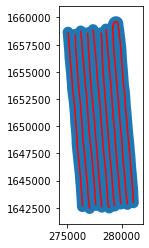

In [ ]:
ax = flightlinebufferdf.plot()
flightlinedf.plot(ax=ax, color='r')

In [ ]:
enclosure = gp.GeoDataFrame({'geometry': [flightlinebufferdf.buffer(1000).unary_union.envelope]})
enclosure.crs = flightlinedf.crs

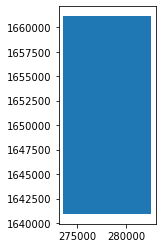

In [ ]:
enclosure.plot()

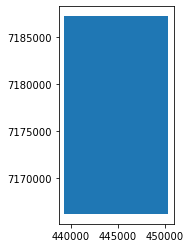

In [ ]:
enclosure_6N = gp.GeoDataFrame({'geometry': list(enclosure.to_crs("EPSG:32606").envelope)})
enclosure_6N.plot()

In [ ]:
type(enclosure_6N)

geopandas.geodataframe.GeoDataFrame

### Case 1: DEM tiles from EarthExplorer. Per dataset there is 1 directory with 1 TIFF file and 1 Shapefile for the extent

In [ ]:
case = 1
DEM_tilesdir = "Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR\\FAI_Nugget_Shovel_Military\\DSM\\"

In [ ]:
Tile = namedtuple('Tile', ['tiffile', 'shpfile'])

In [ ]:
tiles = [
    Tile(glob.glob(os.path.join(folder, "*.tif"))[0],
         glob.glob(os.path.join(folder, "*.shp"))[0])
    for folder in glob.glob(os.path.join(DEM_tilesdir, "IFSARAKD*" )) 
    if os.path.isdir(folder)
]


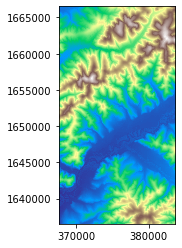

In [ ]:
firsttiff = tiles[0].tiffile
firstraster = rio.open(firsttiff)
show(firstraster, cmap="terrain")

Load all DEM tile footprints, reproject, filter the ones that overlap with the flightline enclosure

In [ ]:
footprints = []
tiffiles = []

for tile in tiles:
    if not gp.overlay(enclosure, gp.read_file(tile.shpfile)).empty:
        footprints.append(gp.read_file(tile.shpfile))
        tiffiles.append(tile.tiffile)

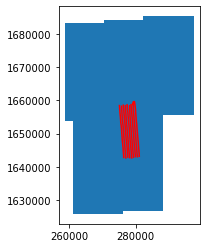

In [ ]:
if footprints:
    allshp = pd.concat(footprints).pipe(gp.GeoDataFrame)
    ax = allshp.plot()
    flightlinedf.plot(ax=ax, color='r')

### Case 2: DEM tiles from The National MAP (TNM). Several TIFF files to a directory. Shapefile with tile index created using `gdaltindex`

In [ ]:
case = 2
DEM_tilesdir = "Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM"

In [ ]:
shplist = [
    (folder, glob.glob(os.path.join(folder, "*.shp"))[0])
    for (folder, dirlist, filelist) in os.walk(DEM_tilesdir)
    if len(glob.glob(os.path.join(folder, "*.shp"))) > 0]

shplist

[('Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell1_2010_TIFF_2015',
  'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell1_2010_TIFF_2015\\cell1_idx.shp'),
 ('Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell2_2010_TIFF_2015',
  'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell2_2010_TIFF_2015\\cell2_idx.shp'),
 ('Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell3_2010_TIFF_2015',
  'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell3_2010_TIFF_2015\\cell3_idx.shp'),
 ('Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\\USGS_NED_Digital_Surface_Model_AK_IFSAR_Cell4_2010_TIFF_2015',
  'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR_DSM_TNM\

In [ ]:
footprints = []
for foldername, shppth in shplist:
    newgdf = gp.read_file(shppth)
    newgdf["foldername"] = foldername
    footprints.append(newgdf)

In [ ]:
polygons = []
tiffiles = []
for footprint in footprints:
    for idx, row in footprint.iterrows():
        if not row["geometry"].intersection(enclosure.geometry[0]).is_empty:
            tiffiles.append(os.path.join(row["foldername"], row["location"]))
            polygons.append(row["geometry"])

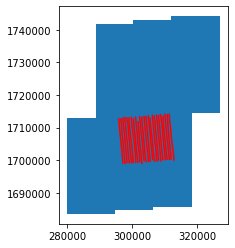

In [ ]:
allshp = gp.GeoDataFrame({"geometry": polygons})
ax = allshp.plot()
flightlinedf.plot(ax=ax, color='r')

### Processing the list of GeoTIFF files

Should resampling be using cubic interpolation or minimal interpolation?

In [ ]:
cubic = True
if not cubic: 
    resampling_reproj = Resampling.nearest
    resampling_downsample = Resampling.bilinear
    fnelem = ''
    global_meta['downsampling'] = 'bilinear'
else:
    resampling_reproj = Resampling.cubic
    resampling_downsample = resampling_reproj
    fnelem = 'cubic_'
    global_meta['downsampling'] = 'cubic'

Load all tiffs that overlap

In [ ]:
rasters = [
    rio.open(tiffile) for tiffile in tiffiles
]

In [ ]:
tiffiles

['Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR\\FAI_Nugget_Shovel_Military\\DSM\\IFSARAKDSM2010N6445W14815_01\\DSM_N6445W14815.tif',
 'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR\\FAI_Nugget_Shovel_Military\\DSM\\IFSARAKDSM2010N6445W14830_01\\DSM_N6445W14830.tif',
 'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR\\FAI_Nugget_Shovel_Military\\DSM\\IFSARAKDSM2010N6430W14815_01\\DSM_N6430W14815.tif',
 'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR\\FAI_Nugget_Shovel_Military\\DSM\\IFSARAKDSM2010N6430W14830_01\\DSM_N6430W14830.tif',
 'Z:\\fihyper\\Shared_Resources\\DEM_raw_tiles\\IFSAR\\FAI_Nugget_Shovel_Military\\DSM\\IFSARAKDSM2010N6445W14800_01\\DSM_N6445W14800.tif']

Merge into a single mosaic

In [ ]:
mosaic, out_trans = rio.merge.merge(rasters)

In [ ]:
out_meta = rasters[0].meta.copy()
out_meta.update(
{
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

In [ ]:
mosaic.shape

(1, 12145, 9446)

In [ ]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 9446,
 'height': 12145,
 'count': 1,
 'crs': CRS.from_epsg(3338),
 'transform': Affine(5.0, 0.0, 279805.0,
        0.0, -5.0, 1744205.0)}

In [ ]:
outfn = os.path.join(projectdir, '01_inputs\DEM', 'aux_IFSAR_mosaic_new.tif')
with rio.open(outfn, "w", **out_meta) as dst:
    dst.write(mosaic)

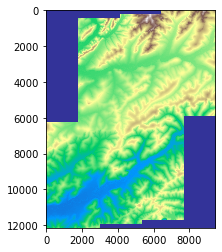

In [ ]:
show(mosaic, cmap="terrain")

Reproject to UTM 6N

In [ ]:
DEM_source_resolution = 5.0   # in m

In [ ]:
dst_crs = "EPSG:32606"
with rasterio.open(os.path.join(projectdir, '01_inputs\DEM', 'aux_IFSAR_mosaic_new.tif')) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=DEM_source_resolution)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(os.path.join(projectdir, '01_inputs\DEM', 'aux_IFSAR_mosaic6N_new.tif'), 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=resampling_reproj)

Crop mosaic to flightline buffer

In [ ]:
with rasterio.open(os.path.join(projectdir, '01_inputs\DEM', 'aux_IFSAR_mosaic6N_new.tif')) as src:
    mosaic_crop_image, mosaic_crop_transform = rasterio.mask.mask(src, list(enclosure_6N.geometry), crop=True)
    mosaic_crop_meta = src.meta.copy()
    mosaic_crop_meta.update({"driver": "GTiff",
                 "height": mosaic_crop_image.shape[1],
                 "width": mosaic_crop_image.shape[2],
                 "transform": mosaic_crop_transform})

In [ ]:
mosaic_crop_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 4377,
 'height': 4104,
 'count': 1,
 'crs': CRS.from_epsg(32606),
 'transform': Affine(5.0, 0.0, 465851.45914161834,
        0.0, -5.0, 7239346.995153848)}

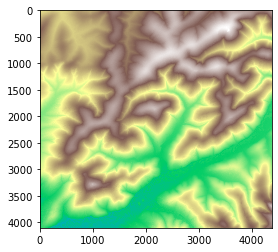

In [ ]:
show(mosaic_crop_image, cmap="terrain")

In [ ]:
outfn = os.path.join(projectdir, '01_inputs\DEM', 'aux_IFSAR_mosaic_crop6N_new.tif')
with rio.open(outfn, "w", **mosaic_crop_meta) as dst:
    dst.write(mosaic_crop_image)

Resample cropped mosaic to final resolution (1m), and save to ENVI BSQ format

In [ ]:
# target_res = 1.0           # target resolution in m
upscale_factor = 5.0       # from 5 m to 1 m  -- this works only if the pixel res remains exactly 5.0m, but after reprojecting there's a rounding error

with rio.open(outfn) as dataset:
#    upscale_factor = dataset.meta['transform'].a/target_res
    out_data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=resampling_downsample
    )

    # scale image transform
    out_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / out_data.shape[-1]),
        (dataset.height / out_data.shape[-2])
    )

In [ ]:
out_meta = dataset.meta.copy()
out_meta.update({"driver": "ENVI",
                 "height": out_data.shape[1],
                 "width": out_data.shape[2],
                 "transform": out_transform})

In [ ]:
out_meta

{'driver': 'ENVI',
 'dtype': 'float32',
 'nodata': None,
 'width': 21885,
 'height': 20520,
 'count': 1,
 'crs': CRS.from_epsg(32606),
 'transform': Affine(1.0, 0.0, 465851.45914161834,
        0.0, -1.0, 7239346.995153848)}

In [ ]:
outfn = os.path.join(projectdir, '01_inputs\DEM', f'IFSAR_crop_1m_{fnelem}main.bsq')
with rio.open(outfn, "w", **out_meta) as dst:
    dst.write(out_data)

### Finalize and persist metadata file

In [ ]:
if case == 1:
    tileidstring = ','.join([os.path.split(os.path.split(name)[0])[1] for name in tiffiles])
    global_meta["DEM_tile_IDs"] = tileidstring
    print(f"Metadata DEM_tile_IDs set to {tileidstring}")
    print("Please set any other desired metadata keys manually")
elif case == 2:
    tileidstring = ','.join(['IFSAR_' + os.path.split(name)[1] for name in tiffiles])
    global_meta["DEM_tile_IDs"] = tileidstring
    print(f"Metadata DEM_tile_IDs set to {tileidstring}")
    print("Please set any other desired metadata keys manually")
else:
    print("Please set IFSAR tile id string and any other metadata manually")

Metadata DEM_tile_IDs set to IFSAR_DSM_n6500w14730P.tif,IFSAR_DSM_n6500w14745P.tif,IFSAR_DSM_n6500w14800P.tif,IFSAR_DSM_n6515w14715P.tif,IFSAR_DSM_n6515w14730P.tif,IFSAR_DSM_n6515w14745P.tif
Please set any other desired metadata keys manually


In [ ]:
outfn = os.path.join(projectdir, '01_inputs\DEM', f'IFSAR_crop_1m_{fnelem}main_meta.txt')
with open(outfn, "w") as dst:
    json.dump(global_meta, dst, indent=2)
    

---

---